In [5]:
sc.stop()
from pyspark import SparkContext 
sc = SparkContext()


In [1]:
numPartitions = 6
baseDir = os.path.join('hdfs://ns372208.ip-91-121-199.eu/extract')
TwoMonthFilename = os.path.join(baseDir, 'extract08-08_10-08.tsv')

rawRatings = sc.textFile(TwoMonthFilename).repartition(numPartitions)

In [2]:
logs = rawRatings.map(lambda line: line.split('\t'))

In [3]:
ProductList = (logs
               .map(lambda x:(x[6],1))
               .reduceByKey(lambda x,y : x+y)
               .keys()
               .collect()
               )


products_ints = dict()
ints_products = dict()

# iterate over all products labelled and mapping with a int rather 
i = 1
for product in ProductList:
    products_ints[product] = i
    ints_products[i] = product   
    i = i + 1


UserList =  (logs
             .map(lambda x:(x[0],1))
             .reduceByKey(lambda x,y : x+y)
             .keys()
             .collect()
            )

users_ints = dict()
ints_users = dict()

# iterate over all user hexa id and mapping with a int rather
i = 1
for user in UserList:
    users_ints[user] = i
    ints_users[i] = user   
    i = i + 1

logs = logs.map(lambda x:(users_ints[x[0]],x[1],x[2],x[3],x[4],x[5], products_ints[x[6]])).cache()
logs.take(1)

[(286473,
  u'55efd8690cf2bf3f9affb188',
  u'Wed Sep 09 2015 08:57:51 GMT+0200 (CEST)',
  u'11369',
  u'10',
  u'access offer page',
  309)]

# <span style="color:red">SEPARATION LOGS RASSEMBLES PAR TYPE</span> #

In [4]:

cartLogs = (logs 
            .filter(lambda x : x[5] in ('remove from cart','add to cart'))
           )
accessOfferLogs = (logs 
            .filter(lambda x : x[5] in ('access offer page'))
            .filter(lambda x : x[3] != '0')
           )
oddLogs = (logs 
            .filter(lambda x : x[5] in ('userActionLabel'))
           )

print cartLogs.take(3)
print accessOfferLogs.take(3)
print oddLogs.take(3)

[(636015, u'55eda90c0cf26fa8c8c3190a', u'Mon Sep 07 2015 17:12:42 GMT+0200 (CEST)', u'0', u'3', u'add to cart', 2328), (157763, u'55fd19180cf284360867357c', u'Sat Sep 19 2015 10:14:25 GMT+0200 (CEST)', u'0', u'3', u'add to cart', 11), (356951, u'55fd19180cf2f3ddc6fb6718', u'Sat Sep 19 2015 10:15:10 GMT+0200 (CEST)', u'0', u'3', u'add to cart', 1893)]
[(286473, u'55efd8690cf2bf3f9affb188', u'Wed Sep 09 2015 08:57:51 GMT+0200 (CEST)', u'11369', u'10', u'access offer page', 309), (436759, u'5605159c0cf229cd083a9a14', u'Fri Sep 25 2015 11:36:28 GMT+0200 (CEST)', u'11815', u'10', u'access offer page', 553), (610442, u'55fd19a50cf2f3ddc6fb67e7', u'Sat Sep 19 2015 10:15:50 GMT+0200 (CEST)', u'70495', u'10', u'access offer page', 1383)]
[(46567, u'sessionId', u'minEventDateTime', u'duration', u'userActionId', u'userActionLabel', 1315)]


# <span style="color:red"> SUPRESSION DES ACCESS LOGS UNIQUES PAR USER </span>#
### Le collaborative filtering algorithm n'est pas capable de prédire des ratings à froid ###
#### (Préférer plutôt un modele baseline pour le cold start ou pour les users non identifiés) ####

In [ ]:
onlyOneAccessOfferLogUserList = (accessOfferLogs
                                 .map(lambda x : ((x[0],x[6]),1))
                                 .reduceByKey(lambda x,y : x+y)
                                 .map(lambda ((x,y),z): (x,1))
                                 .reduceByKey(lambda x,y : x+y)
                                 .filter(lambda (x,y) : y==1)
                                 .map(lambda (x,y): x)
                                 .collect()
                                 )
print len(onlyOneAccessOfferLogUserList)
accessOfferLogsNonFiltered = accessOfferLogs
print accessOfferLogsNonFiltered.count()
# The list could be huge, so we broadcast it through the cluster 
# Other optimisation clue : Translate User Id into integers ..... 



In [6]:
sharedList = sc.broadcast(onlyOneAccessOfferLogUserList)

accessOfferLogs = accessOfferLogs.filter(lambda x : x[0] not in (sharedList.value) )
print accessOfferLogs.count()

252408


In [7]:
accessOfferLogs.saveAsTextFile('hdfs://ns372208.ip-91-121-199.eu/extract/extract08-08_10-08_onlyAccessOfferLogsFILTERED.tsv')

In [16]:
from ast import literal_eval as make_tuple
baseDir = os.path.join('hdfs://ns372208.ip-91-121-199.eu/extract')
TwoMonthFilename = os.path.join(baseDir, 'extract08-08_10-08_onlyAccessOfferLogsFILTERED.tsv')
accessOfferLogs = sc.textFile(TwoMonthFilename).repartition(4)
accessOfferLogs = accessOfferLogs.map(lambda line: make_tuple(line))
print accessOfferLogs.take(5)

[(236496, u'55fd19720cf202afa3113d4c', u'Sat Sep 19 2015 10:17:18 GMT+0200 (CEST)', u'4638', u'10', u'access offer page', 731), (192655, u'55efd81e0cf2984be565e9aa', u'Wed Sep 09 2015 08:56:30 GMT+0200 (CEST)', u'15884', u'10', u'access offer page', 2972), (607279, u'55fd18fa0cf2ef6bb4d26756', u'Sat Sep 19 2015 10:36:07 GMT+0200 (CEST)', u'3112', u'10', u'access offer page', 1536), (88987, u'55fd181d0cf202afa3113bbd', u'Sat Sep 19 2015 10:09:01 GMT+0200 (CEST)', u'8615', u'10', u'access offer page', 3236), (377423, u'55efd6af0cf2984be565e828', u'Wed Sep 09 2015 08:58:36 GMT+0200 (CEST)', u'37767', u'10', u'access offer page', 1974)]


In [17]:
print accessOfferLogs.filter(lambda x : x[3]== '0').count()
print accessOfferLogs.count()

0
252408


## Gestion des "NaN values" ## 

In [18]:
def returnMeANumber(string):
    if string.isdigit():
        return int(string)
    else:
        return 0
    
  

### Use cases ###
* #### 'access offer page' / duration : 0  ===> Pas d'action spécifiques donc interet très faible ####
* #### 'add to cart' / duration = 0 toujours ===> Interet fort ####


In [19]:
############ TIME & DATE Labo ##########################################
import time
x = 'Sat Sep 19 2015 10:15:10 GMT+0200 (CEST)'
y = 'Sat Sep 19 2015 10:15:09 GMT+0200 (CEST)'
print x[:-16]
print time.strptime(x[:-16],"%a %b %d %Y %H:%M:%S") > time.strptime(y[:-16],"%a %b %d %Y %H:%M:%S")

Sat Sep 19 2015 10:15:10
True


In [20]:
import time
def agregOneProductCartActions(x,y):
    print x
    xTimeString = x[0]
    yTimeString = y[0]
    xTime = time.strptime(xTimeString[:-16], "%a %b %d %Y %H:%M:%S")
    yTime = time.strptime(yTimeString[:-16], "%a %b %d %Y %H:%M:%S")
    returnTime = xTimeString if xTime > yTime else yTimeString
    return (returnTime, 0, x[2]+y[2])

def agregOneProductAccessOfferActions(x,y):
    print x
    xTimeString = x[0]
    yTimeString = y[0]
    xTime = time.strptime(xTimeString[:-16], "%a %b %d %Y %H:%M:%S")
    yTime = time.strptime(yTimeString[:-16], "%a %b %d %Y %H:%M:%S")
    returnTime = xTimeString if xTime > yTime else yTimeString
    return (returnTime, x[1]+y[1])
    

In [21]:
aggregCartLogs = (cartLogs
                  .map(lambda (a,b,c,d,e,f,g) : ((a,g),(c,d,1)) if f == 'add to cart' else ((a,g),(c,d,-1)))
                  .reduceByKey(agregOneProductCartActions)
                  )
aggregCartLogs.take(5)

[((464638, 1580), (u'Wed Aug 19 2015 18:29:07 GMT+0200 (CEST)', u'0', 1)),
 ((147365, 639), (u'Mon Aug 24 2015 17:26:08 GMT+0200 (CEST)', u'0', 1)),
 ((324484, 458), (u'Fri Oct 09 2015 00:26:02 GMT+0200 (CEST)', u'0', 1)),
 ((632750, 484), (u'Sat Oct 03 2015 11:29:31 GMT+0200 (CEST)', u'0', 1)),
 ((227689, 2339), (u'Tue Sep 01 2015 15:10:08 GMT+0200 (CEST)', u'0', 1))]

## Anomalies pour les actions de type "CART" ##
#### logiquement, après agréggation des 'add' (+1) et 'remove' (-1), l'on ne devrait PAS avoir de valeurs négatives dans le décompte pour le couple (utilisateur, produit). ####
##### Hypothéses : #####
* ##### Certaines valeurs négatives peuvent être expliquées par l'absence des précédentes 'add' actions puisque loggé juste avant la begin date du fichier de logs considéré  ###### 

In [22]:

print aggregCartLogs.map(lambda x : x[1][2]).countByValue()

defaultdict(<type 'int'>, {0: 9376, 1: 67808, 2: 9025, 3: 1792, 4: 533, 5: 180, 6: 94, 7: 65, 8: 28, 9: 29, 10: 18, 11: 15, 12: 13, 13: 10, 14: 4, 15: 6, 16: 4, 17: 2, 18: 2, 19: 1, 20: 2, 21: 2, 22: 1, 23: 2, 26: 2, 29: 1, 30: 3, 37: 1, 38: 1, 40: 2, 42: 1, 48: 1, 49: 1, 60: 1, 80: 1, -25: 1, -17: 1, -15: 1, -1: 564, -10: 1, -7: 3, -6: 2, -5: 13, -4: 20, -3: 51, -2: 160})


In [23]:
ReadyCartLogs = aggregCartLogs.map(lambda ((k1,k2),(x,y,z)) : ((k1,k2),4.0) if z > 0 else ((k1,k2),2.0) ).cache()

ReadyCartLogs.take(1)

[((464638, 1580), 4.0)]

In [24]:
print accessOfferLogs.count()
aggregAccessOfferLogs = (accessOfferLogs
                  .map(lambda (a,b,c,d,e,f,g) : ((a,g),(c,returnMeANumber(d))))
                  .reduceByKey(agregOneProductAccessOfferActions)
                  )

aggregAccessOfferLogs.take(3)



252408


[((464638, 1580), (u'Wed Aug 19 2015 18:27:55 GMT+0200 (CEST)', 71511)),
 ((475240, 2774), (u'Wed Oct 07 2015 09:11:38 GMT+0200 (CEST)', 4103)),
 ((37292, 1134), (u'Thu Aug 27 2015 13:25:26 GMT+0200 (CEST)', 4688))]

   ## <span style="color:red">Managing extreme values : assigning a cap value </span>##

In [25]:
print aggregAccessOfferLogs.filter(lambda x : int(x[1][1])>150000).count() 
logs_in_ms = aggregAccessOfferLogs.filter(lambda x : int(x[1][1])>100000).map(lambda x : int(x[1][1])).collect()

5251


In [17]:
import numpy as np 
print "Min : %d" %(min(logs_in_ms))
print "Max : %d" %(max(logs_in_ms))


plt.hist(logs_in_ms,range=[90000, 500000])
plt.title("Logs in ms")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

NameError: name 'logs_in_ms' is not defined

#### Assigning a cap calue of 150.000 for all above extreme values ####

In [26]:
extremeCappedAggregAccessOfferLogs = aggregAccessOfferLogs.map(lambda x : ((x[0][0],x[0][1]),(x[1][0],100000)) if int(x[1][1])>100000 else x)

## Normalisation ##

In [27]:
#################### Prends beaucoup de temps ######################
mean = extremeCappedAggregAccessOfferLogs.map(lambda x : int(x[1][1])).mean()
std = extremeCappedAggregAccessOfferLogs.map(lambda x : int(x[1][1])).stdev()
print mean
print std

28905.7249373
27328.8319855


In [19]:
mean = 16796.2444516
std = 28172.0146034

In [28]:

def round_to(n, precision):
    correction = 0.5 if n >= 0 else -0.5
    return int( n/precision+correction ) * precision

def round_to_05(n):
    return round_to(n, 0.05)

print round_to_05(18.75698)

18.75


In [29]:
ReadyAccessOfferLogs = (extremeCappedAggregAccessOfferLogs
                  .map(lambda ((k1,k2),(x,y)) : ((k1,k2), round_to_05((y-mean)/std) ))
                  )
ReadyAccessOfferLogs.take(5)

[((350808, 1374), 2.1),
 ((475240, 2774), -0.9),
 ((37292, 1134), -0.9),
 ((464638, 1580), 1.55),
 ((229222, 2108), -0.65)]

In [30]:
print ReadyAccessOfferLogs.take(5)
print ReadyCartLogs.take(5)

[((438668, 1134), -0.75), ((350808, 1374), 2.1), ((475240, 2774), -0.9), ((37292, 1134), -0.9), ((464638, 1580), 1.55)]
[((464638, 1580), 4.0), ((147365, 639), 4.0), ((324484, 458), 4.0), ((632750, 484), 4.0), ((227689, 2339), 4.0)]


In [31]:
ReadyAllLogs = (ReadyAccessOfferLogs
                .union(ReadyCartLogs)
                .reduceByKey(lambda x,y : x if x > y else y)
                .map(lambda ((x,y),z): (x,y,z))
                .cache()
                )
print ReadyAllLogs.take(1)

[(324484, 458, 4.0)]


In [32]:

trainingRDD, validationRDD, testRDD = ReadyAllLogs.randomSplit([6, 2, 2], seed=0L) 

# BASELINE #

In [33]:
def Build_Baseline_RDD(refRDD, testRDD):
        mu = refRDD.map(lambda x : x[2]).mean()
        print mu
        userAverageRatings = (refRDD
                              .map(lambda x : (x[0],(x[2],1)))
                              .reduceByKey(lambda x,y : (x[0]+y[0], x[1]+y[1]))
                              .map(lambda (x,(y,z)): (x,(y-mu)/z))
                              .collect()
                              )

        productAverageRatings = (refRDD
                              .map(lambda x : (x[1],(x[2],1)))
                              .reduceByKey(lambda x,y : (x[0]+y[0], x[1]+y[1]))
                              .map(lambda (x,(y,z)): (x,(y-mu)/z))
                              .collect()
                              )
       
        userList = dict(userAverageRatings)
        productList = dict(productAverageRatings)
        
        baselineRDD = testRDD.map(lambda (x,y) : (x,y, mu + userList[x]+productList[y]))
        
        return baselineRDD

In [34]:
# TODO: Replace <FILL IN> with appropriate code
import math
def auditError(predictedRDD, actualRDD):
    
    # Transform predictedRDD into the tuples of the form ((UserID, MovieID), Rating)
    predictedReformattedRDD = predictedRDD.map(lambda (x,y,z) : ((x,y),z))

    # Transform actualRDD into the tuples of the form ((UserID, MovieID), Rating)
    actualReformattedRDD = actualRDD.map(lambda (x,y,z) : ((x,y),z))
    
    
    
    
def computeError(predictedRDD, actualRDD):
    """ Compute the root mean squared error between predicted and actual
    Args:
        predictedRDD: predicted ratings for each movie and each user where each entry is in the form
                      (UserID, MovieID, Rating)
        actualRDD: actual ratings where each entry is in the form (UserID, MovieID, Rating)
    Returns:
        RSME (float): computed RSME value
    """
    # Transform predictedRDD into the tuples of the form ((UserID, MovieID), Rating)
    predictedReformattedRDD = predictedRDD.map(lambda (x,y,z) : ((x,y),z))

    # Transform actualRDD into the tuples of the form ((UserID, MovieID), Rating)
    actualReformattedRDD = actualRDD.map(lambda (x,y,z) : ((x,y),z))

    # Compute the squared error for each matching entry (i.e., the same (User ID, Movie ID) in each
    # RDD) in the reformatted RDDs using RDD transformtions - do not use collect()
    squaredErrorsRDD = (predictedReformattedRDD
                        .join(actualReformattedRDD)
                        .map(lambda ((x,y),(a,b)):((x,y),math.pow(a-b,2)) )
                       )

    # Compute the total squared error - do not use collect()
    #totalError = squaredErrorsRDD.reduce(lambda (a,b),(c,d) : b+d)
    totalError = squaredErrorsRDD.map(lambda ((x,y),z) : z).sum()

    # Count the number of entries for which you computed the total squared error
    numRatings = squaredErrorsRDD.count()

    # Using the total squared error and the number of entries, compute the RSME
    return math.sqrt(totalError/numRatings)


# sc.parallelize turns a Python list into a Spark RDD.
testPredicted = sc.parallelize([
    (1, 1, 5),
    (1, 2, 3),
    (1, 3, 4),
    (2, 1, 3),
    (2, 2, 2),
    (2, 3, 4)])
testActual = sc.parallelize([
     (1, 2, 3),
     (1, 3, 5),
     (2, 1, 5),
     (2, 2, 1)])
testPredicted2 = sc.parallelize([
     (2, 2, 5),
     (1, 2, 5)])
testError = computeError(testPredicted, testActual)
print 'Error for test dataset (should be 1.22474487139): %s' % testError

testError2 = computeError(testPredicted2, testActual)
print 'Error for test dataset2 (should be 3.16227766017): %s' % testError2

testError3 = computeError(testActual, testActual)
print 'Error for testActual dataset (should be 0.0): %s' % testError3

Error for test dataset (should be 1.22474487139): 1.22474487139
Error for test dataset2 (should be 3.16227766017): 3.16227766017
Error for testActual dataset (should be 0.0): 0.0


In [40]:
# TODO: Replace <FILL IN> with appropriate code
from pyspark.mllib.recommendation import ALS

validationForPredictRDD = validationRDD.map(lambda  (x,y,z): (x,y)).cache()

seed = 5L
iterations = 30
regularizationParameter = 0.1
ranks = [ 24, 30]
errors = [0, 0]
err = 0
tolerance = 0.03

minError = float('inf')
bestRank = -1
bestIteration = -1
for rank in ranks:
    model = ALS.train(trainingRDD, rank, seed=seed, iterations=iterations,
                      lambda_=regularizationParameter)
    predictedRatingsRDD = model.predictAll(validationForPredictRDD)
    error = computeError(predictedRatingsRDD, validationRDD)
    errors[err] = error
    err += 1
    print 'For rank %s the RMSE is %s' % (rank, error)
    if error < minError:
        minError = error
        bestRank = rank

print 'The best model was trained with rank %s' % bestRank

For rank 24 the RMSE is 1.58160378106
For rank 30 the RMSE is 1.58066498074
The best model was trained with rank 30


In [57]:
mylist =  validationRDD.map(lambda x : (x[2],1)).reduceByKey(lambda x,y : x+y).collect()

## Confront with baseline figures ##

In [37]:
baselineValidationSetRDD = Build_Baseline_RDD(ReadyAllLogs, validationForPredictRDD)
print baselineValidationSetRDD.take(20)

1.01855229746
[(353082, 2556, 1.8601051605358498), (637849, 711, 2.927472511782236), (528077, 535, 5.3503788265234205), (640384, 1134, 3.156431289406482), (23983, 553, 2.7064743014675283), (650986, 1016, 3.1257688809519983), (183742, 1374, 1.8031472422104884), (149648, 858, 5.734391367992785), (145345, 503, 1.4132085992738814), (113249, 2203, -0.04202780773096539), (437707, 1993, 1.2859504722760557), (669636, 908, 5.662316953342696), (500891, 2391, 1.8844960901555963), (566319, 375, 2.1328961832780666), (458304, 1670, 2.4434866266256936), (563268, 3170, 0.5257718755806406), (149250, 580, 1.2784901384512635), (636036, 2632, 3.7431958914459282), (530768, 752, 1.0901962070848203), (212872, 2756, 0.13941248175422438)]


In [38]:
testRMSE = computeError(validationRDD, baselineValidationSetRDD)
print testRMSE

1.92426438098


In [58]:
import csv

with open("toto.csv", 'wb') as f :
    wr = csv.writer(f)
    wr.writerows(mylist)



In [53]:
#### Lister les profiles utilisateurs par nombre de produits différents consultés ############
UserActionProfiles = (ReadyAllLogs
                     .map(lambda(x,y,z):(x,1))
                     .reduceByKey(lambda x,y : x+y)
                     .map(lambda (x,y):(y,1))
                     .reduceByKey(lambda x,y : x+y)
                     .collect()
                     )

In [54]:
print UserActionProfiles

[(24, 3), (12, 131), (1, 550495), (37, 1), (13, 99), (25, 4), (2, 83281), (26, 4), (14, 64), (39, 2), (3, 27223), (15, 56), (16, 25), (28, 1), (4, 12314), (40, 1), (17, 24), (5, 5987), (41, 1), (18, 16), (54, 1), (30, 3), (6, 3318), (43, 1), (19, 19), (7, 1671), (8, 946), (32, 2), (20, 4), (9, 565), (21, 8), (10, 379), (22, 9), (47, 1), (11, 216), (23, 6)]


In [60]:
NotationProfiles = (testRDD
                    .map(lambda (x,y,z): (z,1))
                    .reduceByKey(lambda x,y : x+y)
                    .filter(lambda (x,y):x <= -0.1)
                    .takeOrdered(10)

                    )
print NotationProfiles

[(-0.4, 76351), (-0.35000000000000003, 10684), (-0.30000000000000004, 8545), (-0.25, 7405), (-0.2, 6360), (-0.15000000000000002, 5686), (-0.1, 4896)]


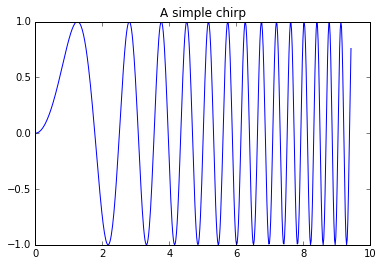

In [62]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
x = np.linspace(0, 3*np.pi, 500)
plt.plot(x, np.sin(x**2))
plt.title('A simple chirp')
plt.show()

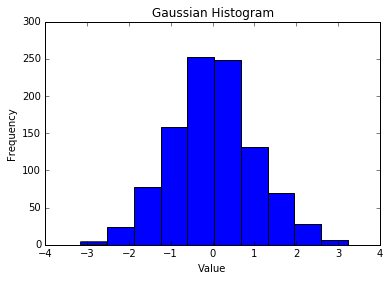

In [63]:
from numpy.random import normal
gaussian_numbers = normal(size=1000)
plt.hist(gaussian_numbers)
plt.title("Gaussian Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

In [ ]:

myModel = ALS.train(trainingRDD, 20, seed=seed, iterations=iterations,
                      lambda_=regularizationParameter)
testForPredictingRDD = testRDD.map(lambda (x,y,z) : (x,y)).cache()
predictedTestRDD = myModel.predictAll(testForPredictingRDD)

testRMSE = computeError(testRDD, predictedTestRDD)

print 'The model had a RMSE on the test set of %s' % testRMSE